In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import numpy as np
import pandas as pd
import sys 
sys.path.append("../../")
sys.path.append("../../src/")
sys.path.append("../../src/model")
from src.model import ddsm as ddsm
from src.model import ddsm_model as modeld
from src.model.lightning_model_diffusion import LightningDiffusion as lightning_dif

import scipy as sp
from matplotlib import pyplot as plt

import wandb
wandb.login(host="https://api.wandb.ai") 


/home/ueharam1/miniconda3/envs/testgrelu/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: masatoshi136 (masa136). Use `wandb login --relogin` to force relogin


True

# Load pre-trained model 

In [2]:
run = wandb.init() # Change depending on your proejcts
artifact = run.use_artifact('fderc_diffusion/Diffusion-DNA-RNA/DNA-model:v0')
dir = artifact.download()
wandb.finish()

class ModelParameters:
    diffusion_weights_file = 'artifacts/DNA-dataset:v0/steps400.cat4.speed_balance.time4.0.samples100000.pth'
    time_schedule = "artifacts/DNA-dataset:v0/time_dependent.npz"
    checkpoint_path = 'artifacts/DNA-model:v0/diffusion_unconditional_epoch=054.ckpt'
config = ModelParameters() 
DEVICE = "cuda:4" # Any number is fine


wandb: Downloading large artifact DNA-model:v0, 1318.41MB. 3 files... 
wandb:   3 of 3 files downloaded.  
Done. 0:0:1.7


In [3]:
# Introduce Two Models
score_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
score_model = score_model.model
score_model.cuda(device = DEVICE) 


original_model = lightning_dif.load_from_checkpoint(checkpoint_path= config.checkpoint_path, weight_file = config.diffusion_weights_file, time_schedule = config.time_schedule, all_class_number =1)
original_model = original_model.model
original_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [4]:
# Load Reward model
from grelu.lightning import LightningModel
model = LightningModel.load_from_checkpoint("artifacts/DNA-model:v0/reward_model.ckpt")
model.eval()
model.to(DEVICE)

def new_reward_model(x):
    x = torch.nn.functional.softmax(x /0.1, -1)
    seq = torch.transpose(x, 1, 2) 
    return model(seq)[:,0]


wandb: Downloading large artifact human_state_dict:latest, 939.29MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.8


In [5]:
from src.model import ddsm_PPO  as fine_tune

import os
save_name = "./log_finetune2/"
isExist = os.path.exists(save_name)
if not isExist:
   os.makedirs(save_name)

loss_curves, eval_curves = fine_tune.fine_tuning(score_model, new_reward_model, [new_reward_model], original_model,
            learning_rate = 5e-3, num_epoch = 1000, length = 50, num_steps = 50, accmu = 6, \
            batch_size = 128, save_name = save_name, entropy_coff = 0.0,  device= DEVICE)

100%|██████████| 50/50 [00:01<00:00, 36.51it/s]


0.11177435517311096


100%|██████████| 50/50 [00:01<00:00, 33.45it/s]


0.6436773538589478


100%|██████████| 50/50 [00:01<00:00, 33.43it/s]


1.3553037643432617


100%|██████████| 50/50 [00:01<00:00, 36.57it/s]


1.3440114259719849


100%|██████████| 50/50 [00:01<00:00, 36.46it/s]


0.5454477071762085


100%|██████████| 50/50 [00:01<00:00, 34.09it/s]


0.5795614719390869


100%|██████████| 50/50 [00:01<00:00, 34.58it/s]


0.5156399607658386


100%|██████████| 50/50 [00:01<00:00, 36.23it/s]


0.6635069847106934


100%|██████████| 50/50 [00:01<00:00, 36.23it/s]


0.4204998016357422


100%|██████████| 50/50 [00:01<00:00, 35.56it/s]


0.6292417645454407


100%|██████████| 50/50 [00:01<00:00, 34.65it/s]


0.6253448724746704


100%|██████████| 50/50 [00:01<00:00, 34.94it/s]


0.3852459788322449


100%|██████████| 50/50 [00:01<00:00, 35.19it/s]


0.4713476002216339


100%|██████████| 50/50 [00:01<00:00, 31.89it/s]


0.5925474762916565


100%|██████████| 50/50 [00:01<00:00, 35.65it/s]


1.3040945529937744


100%|██████████| 50/50 [00:01<00:00, 35.12it/s]


1.2880568504333496


100%|██████████| 50/50 [00:01<00:00, 34.18it/s]


1.313623309135437


100%|██████████| 50/50 [00:01<00:00, 35.97it/s]


1.3105778694152832


100%|██████████| 50/50 [00:01<00:00, 35.36it/s]


1.3061742782592773


100%|██████████| 50/50 [00:01<00:00, 35.34it/s]


1.3649746179580688


100%|██████████| 50/50 [00:01<00:00, 31.87it/s]


0.9264659881591797


100%|██████████| 50/50 [00:01<00:00, 35.89it/s]


1.5295923948287964


100%|██████████| 50/50 [00:01<00:00, 36.21it/s]


1.3096864223480225


100%|██████████| 50/50 [00:01<00:00, 36.80it/s]


1.1673214435577393


100%|██████████| 50/50 [00:01<00:00, 32.64it/s]


1.223789930343628


100%|██████████| 50/50 [00:01<00:00, 34.78it/s]


1.3362613916397095


100%|██████████| 50/50 [00:01<00:00, 35.83it/s]


1.3418817520141602


100%|██████████| 50/50 [00:01<00:00, 32.93it/s]


1.27060866355896


100%|██████████| 50/50 [00:01<00:00, 35.68it/s]


1.3672330379486084


100%|██████████| 50/50 [00:01<00:00, 36.12it/s]


0.970192551612854


100%|██████████| 50/50 [00:01<00:00, 32.96it/s]


0.6816725730895996


100%|██████████| 50/50 [00:01<00:00, 35.81it/s]


0.7087039947509766


100%|██████████| 50/50 [00:01<00:00, 36.01it/s]


0.6387153267860413


100%|██████████| 50/50 [00:01<00:00, 36.00it/s]


0.6437346935272217


100%|██████████| 50/50 [00:01<00:00, 32.82it/s]


0.6245254278182983


100%|██████████| 50/50 [00:01<00:00, 33.13it/s]


0.6007148623466492


100%|██████████| 50/50 [00:01<00:00, 36.18it/s]


0.5944907665252686


100%|██████████| 50/50 [00:01<00:00, 35.78it/s]


0.5944936275482178


100%|██████████| 50/50 [00:01<00:00, 32.97it/s]


0.5944861173629761


100%|██████████| 50/50 [00:01<00:00, 35.40it/s]


0.5944720506668091


100%|██████████| 50/50 [00:01<00:00, 35.71it/s]


0.5945175886154175


100%|██████████| 50/50 [00:01<00:00, 32.51it/s]


0.5945163369178772


100%|██████████| 50/50 [00:01<00:00, 35.59it/s]


0.5944533348083496


100%|██████████| 50/50 [00:01<00:00, 36.34it/s]


0.5944360494613647


100%|██████████| 50/50 [00:01<00:00, 36.53it/s]


0.594478189945221


100%|██████████| 50/50 [00:01<00:00, 34.23it/s]


0.5972087383270264


100%|██████████| 50/50 [00:01<00:00, 32.87it/s]


0.6022412776947021


100%|██████████| 50/50 [00:01<00:00, 35.60it/s]


1.3646305799484253


100%|██████████| 50/50 [00:01<00:00, 36.24it/s]


1.3677629232406616


100%|██████████| 50/50 [00:01<00:00, 36.07it/s]


1.367734432220459


100%|██████████| 50/50 [00:01<00:00, 33.40it/s]


1.367707371711731


100%|██████████| 50/50 [00:01<00:00, 33.28it/s]


1.3677313327789307


100%|██████████| 50/50 [00:01<00:00, 35.90it/s]


1.367691993713379


100%|██████████| 50/50 [00:01<00:00, 35.94it/s]


0.5984310507774353


100%|██████████| 50/50 [00:01<00:00, 37.07it/s]


0.5945557951927185


100%|██████████| 50/50 [00:01<00:00, 33.23it/s]


0.5944085717201233


100%|██████████| 50/50 [00:01<00:00, 34.34it/s]


0.5944055318832397


100%|██████████| 50/50 [00:01<00:00, 35.76it/s]


0.5944023132324219


100%|██████████| 50/50 [00:01<00:00, 36.28it/s]


0.594374418258667


100%|██████████| 50/50 [00:01<00:00, 35.04it/s]


0.5943928956985474


100%|██████████| 50/50 [00:01<00:00, 34.25it/s]


0.5944028496742249


100%|██████████| 50/50 [00:01<00:00, 33.74it/s]


0.5944357514381409


100%|██████████| 50/50 [00:01<00:00, 35.51it/s]


0.5944441556930542


100%|██████████| 50/50 [00:01<00:00, 36.09it/s]


0.5944123268127441


100%|██████████| 50/50 [00:01<00:00, 34.44it/s]


0.5944465398788452


100%|██████████| 50/50 [00:01<00:00, 32.77it/s]


0.5944198369979858


100%|██████████| 50/50 [00:01<00:00, 36.01it/s]


0.5944299697875977


100%|██████████| 50/50 [00:01<00:00, 36.40it/s]


0.5944415330886841


100%|██████████| 50/50 [00:01<00:00, 34.65it/s]


0.5944516658782959


100%|██████████| 50/50 [00:01<00:00, 32.97it/s]


0.5944666862487793


100%|██████████| 50/50 [00:01<00:00, 35.46it/s]


0.59452885389328


100%|██████████| 50/50 [00:01<00:00, 36.46it/s]


0.5945175886154175


100%|██████████| 50/50 [00:01<00:00, 35.09it/s]


0.5944936871528625


100%|██████████| 50/50 [00:00<00:00, 84.46it/s]


KeyboardInterrupt: 

# Evaluation 

In [20]:
#### Load Fine-Tuned Model 

time_dependent_weights = torch.tensor(np.load(config.time_schedule)['x'])
score_finetuned_model = modeld.ScoreNet(time_dependent_weights=torch.sqrt(time_dependent_weights)) 
score_finetuned_model.load_state_dict(torch.load("./log_finetune2/_83.pth")) # Change here
score_finetuned_model.cuda(device = DEVICE) 

ScoreNet(
  (embed): Sequential(
    (0): GaussianFourierProjection()
    (1): Linear(in_features=256, out_features=256, bias=True)
  )
  (linear): Conv1d(4, 256, kernel_size=(9,), stride=(1,), padding=(4,))
  (blocks): ModuleList(
    (0-1): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (3): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (4): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (5-6): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (7): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(16,), dilation=(4,))
    (8): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(64,), dilation=(16,))
    (9): Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(256,), dilation=(64,))
    (10-11): 2 x Conv1d(256, 256, kernel_size=(9,), stride=(1,), padding=(4,))
    (12

In [21]:
### Get Samples after Fine-tune models 

sampler = ddsm.Euler_Maruyama_sampler


allsamples_original = []
for t in range(5):
    samples=[]
    score_finetuned_model.eval()
    samples.append(sampler(score_finetuned_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 135.14it/s]


In [22]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

generated_samples = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples.append(model(batch).detach().cpu() ) 

generated_samples = np.concatenate(generated_samples)

In [10]:
### Get Samples from Pre-Trained Models 

sampler = ddsm.Euler_Maruyama_sampler

allsamples_original = []
for t in range(5):
    samples=[]
    score_model.eval()
    samples.append(sampler(original_model,
                        (50,4),
                        batch_size=128,
                        new_class = None,
                        class_number = 1,
                        strength = 10, 
                        max_time=  4.0,
                        min_time= 1.0/400,
                        time_dilation=1,
                        num_steps=100, 
                        eps=1e-5,
                        speed_balanced= True,
                        device= DEVICE, 
                        ).cpu().detach().numpy())
    allsamples_original.append(samples)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:00<00:00, 100.36it/s]


In [11]:
allsamples = np.concatenate(allsamples_original, axis=1)
allsamples = allsamples[0,:,:,:]

In [12]:
generated_samples_before = []
data_loader = torch.utils.data.DataLoader(allsamples.astype("float32"), batch_size = 128 , num_workers=0)
for batch in data_loader:
    batch = (batch > 0.5) * torch.ones_like(batch)
    batch = torch.permute(batch, (0, 2, 1)).to(DEVICE)
    generated_samples_before.append( model(batch).detach().cpu() ) 

generated_samples_before = np.concatenate(generated_samples_before)

<Figure size 8000x1000 with 0 Axes>

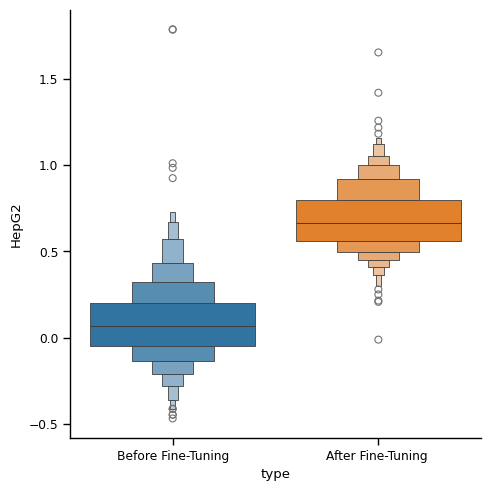

In [23]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(80, 10))

compare = np.concatenate( (generated_samples_before[:,0], generated_samples[:,0]  ), axis= 0)

type1 = ['Before Fine-Tuning' for i in range(len(generated_samples_before[:,0] ))]
#type2 = ['Generated (Strong Sig)' for i in range(len(generated_samples[:,0] ))]
type3 = ['After Fine-Tuning ' for i in range(len(generated_samples[:,0]))]

type =   type1 +  type3
data_dict = {'type': type, 'HepG2': compare[:,0] }
plot_data = pd.DataFrame(data_dict)
fig = sns.catplot(data=plot_data, x = 'type', y =  'HepG2', hue="type", kind="boxen" )
sns.set_context("paper", rc={"figure.figsize": (80, 10)})
#fig.savefig("../media/RNA_output_high.png")



